# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  1.660585  0.713901  0.0  0.459191  0.017529 -0.362507  3  1  11.570679   
1 -0.073337 -1.385139  0.0  0.987380 -0.084114 -0.162316  0  3  19.247642   
2  0.051417  1.190755  0.0  0.934638  1.839692  0.978671  1  2  26.698634   
3 -1.182316 -0.250516  0.0  0.758879  2.120034  1.072243  0  1  22.548338   
4  1.158698  0.359537  0.0  0.068433 -1.623811  2.117884  1  1   3.582696   

            y  
0  195.203966  
1   51.460877  
2  456.056312  
3  172.411274  
4   61.249647  
True causal estimate is 12.289117067079985


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

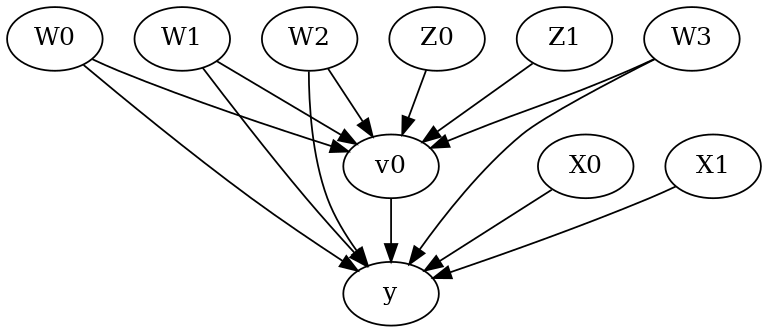

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W2,U) = P(y|v0,W3,W0,W1,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W2,U) = P(y|v0,W3,W0,W1,W2)

## Realized estimand
b: y~v0+W3+W0+W1+W2+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 12.2891851934011
### Conditional Estimates
__categorical__X1  __categorical__X0           
(-3.142, -0.288]   (-4.816000000000001, -1.442]     2.870040
                   (-1.442, -0.854]                 4.039179
                   (-0.854, -0.349]                 4.602624
                   (-0.349, 0.22]                   5.384766
                   (0.22, 3.339]                    6.328198
(-0.288, 0.314]    (-4.816000000000001, -1.442]     7.663791
                   (-1.442, -0.854]                 8.696944
                   (-0.854, -0.349]             

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W2,U) = P(y|v0,W3,W0,W1,W2)

## Realized estimand
b: y~v0+W3+W0+W1+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 15.184452556274088
Effect estimates: [ 1.60220392e+01  1.34428895e+01  2.82595863e+01  1.68191290e+01
  1.12226126e+01  1.57335597e+01  2.07987584e+01  1.22558721e+01
  7.41386153e+00  5.96179483e+00  1.93969528e+01  1.77345949e+01
  1.52045448e+01  1.56004577e+01  2.47416382e+01  1.88837227e+01
  2.26262726e+01  6.12470151e+00  2.98788479e+01  2.06849731e+01
  8.51595599e+00  1.57623178e+01  1.67136931e+01  1.01642861e+01
  1.96817876e+01  1.05924782e+01  9.40220080e+00  8.28650414e+00
  1.56527323e+01  1.02302681e+01  1.27975700e+01

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 12.289117067079985


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W2,U) = P(y|v0,W3,W0,W1,W2)

## Realized estimand
b: y~v0+W3+W0+W1+W2 | X1,X0
Target units: 

## Estimate
Mean value: 12.20373212487076
Effect estimates: [15.89012734  2.35884708 16.42185355 ...  0.79760776 17.21154153
 15.84640401]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W2,U) = P(y|v0,W3,W0,W1,W2)

## Realized estimand
b: y~v0+W3+W0+W1+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 12.18830549083644
Effect estimates: [15.87898119  2.37875693 16.39758184 ...  0.81110704 17.17756063
 15.81035785]
95.0% confidence interval: (array([15.88126189,  2.07159426, 16.45945658, ...,  0.48056315,
       17.2139434 , 15.77300145]), array([16.28264066,  2.45912248, 16.79327391, ...,  0.87194842,
       17.62262036, 16.24674435]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[12.39273632 11.51861754 12.47655623 14.48559419 11.38104539 11.37865909
 16.07926263 13.32850844 13.41942277 15.25423217]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0     1.180128  0.095734  1.0  0.616454 -1.805845 -1.021574 -0.832680   
1     0.893757 -0.501795  1.0  0.830844 -1.823705  0.218628 -0.506976   
2    -2.454523 -1.382546  0.0  0.199415  0.815442  0.493182 -1.297293   
3    -1.316992 -1.606214  0.0  0.100236 -0.046319  0.240143 -0.764946   
4     1.418555 -2.336671  0.0  0.934807 -0.774327 -1.715648  0.252924   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.571248  0.266713  1.0  0.093067 -0.787031 -2.228804 -0.168025   
9996 -0.473276 -1.320769  1.0  0.866985 -1.892778 -0.488178 -1.792457   
9997 -0.857257 -0.114567  1.0  0.227375 -0.827107 -0.882234  1.145447   
9998 -0.196924 -1.261090  1.0  0.871052 -1.363253 -0.335003 -1.297684   
9999 -0.629104 -0.186898  1.0  0.527144 -0.954639 -2.234450 -1.044452   

            W3  v0  y  
0    -0.345623   1  1  
1    -0.146641   1  1  
2    -0.525042   1  0  
3     1.215787   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W2,U) = P(y|v0,W3,W0,W1,W2)

## Realized estimand
b: y~v0+W3+W0+W1+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 0.3933064781680764
Effect estimates: [ 0.70425026  0.58566607 -0.007768   ...  0.3854489   0.33099873
  0.40869519]

True causal estimate is 0.2517


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-11-14 22:09:22.105999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 22:09:22.300832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-14 22:09:22.300877: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-11-14 22:09:22.350161: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2022-11-14 22:09:23.309115: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-14 22:09:23.309301: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-14 22:09:23.309317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2022-11-14 22:09:24.454895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-14 22:09:24.454937: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-14 22:09:24.454964: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (46acfa8315d3): /proc/driver/nvidia/version does not exist
2022-11-14 22:09:24.455736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 4:28 - loss: 131.7208

 26/313 [=>............................] - ETA: 0s - loss: 61.5447   

 52/313 [===>..........................] - ETA: 0s - loss: 34.5564

 78/313 [======>.......................] - ETA: 0s - loss: 24.8805

106/313 [=========>....................] - ETA: 0s - loss: 19.6329

133/313 [===========>..................] - ETA: 0s - loss: 16.5990

159/313 [==============>...............] - ETA: 0s - loss: 14.6302

186/313 [================>.............] - ETA: 0s - loss: 13.1269

213/313 [===================>..........] - ETA: 0s - loss: 11.9899

240/313 [======================>.......] - ETA: 0s - loss: 11.1021

266/313 [========================>.....] - ETA: 0s - loss: 10.4049

292/313 [==========================>...] - ETA: 0s - loss: 9.8239 

313/313 [==============================] - 1s 2ms/step - loss: 9.4212


Epoch 2/25


  1/313 [..............................] - ETA: 0s - loss: 3.4918

 28/313 [=>............................] - ETA: 0s - loss: 3.7057

 55/313 [====>.........................] - ETA: 0s - loss: 3.6879

 82/313 [======>.......................] - ETA: 0s - loss: 3.6373

109/313 [=========>....................] - ETA: 0s - loss: 3.5803

134/313 [===========>..................] - ETA: 0s - loss: 3.5330

161/313 [==============>...............] - ETA: 0s - loss: 3.4705

188/313 [=================>............] - ETA: 0s - loss: 3.4153

215/313 [===================>..........] - ETA: 0s - loss: 3.3737

243/313 [======================>.......] - ETA: 0s - loss: 3.3272

270/313 [========================>.....] - ETA: 0s - loss: 3.2929

296/313 [===========================>..] - ETA: 0s - loss: 3.2586

313/313 [==============================] - 1s 2ms/step - loss: 3.2382


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 3.0019

 27/313 [=>............................] - ETA: 0s - loss: 2.8546

 53/313 [====>.........................] - ETA: 0s - loss: 2.8804

 80/313 [======>.......................] - ETA: 0s - loss: 2.8529

107/313 [=========>....................] - ETA: 0s - loss: 2.8345

132/313 [===========>..................] - ETA: 0s - loss: 2.8227

159/313 [==============>...............] - ETA: 0s - loss: 2.8152

186/313 [================>.............] - ETA: 0s - loss: 2.8185

212/313 [===================>..........] - ETA: 0s - loss: 2.8142

238/313 [=====================>........] - ETA: 0s - loss: 2.8146

263/313 [========================>.....] - ETA: 0s - loss: 2.8076

287/313 [==========================>...] - ETA: 0s - loss: 2.8039

313/313 [==============================] - 1s 2ms/step - loss: 2.8028


Epoch 4/25


  1/313 [..............................] - ETA: 0s - loss: 2.9418

 28/313 [=>............................] - ETA: 0s - loss: 2.8242

 55/313 [====>.........................] - ETA: 0s - loss: 2.7691

 82/313 [======>.......................] - ETA: 0s - loss: 2.7563

109/313 [=========>....................] - ETA: 0s - loss: 2.7490

136/313 [============>.................] - ETA: 0s - loss: 2.7381

161/313 [==============>...............] - ETA: 0s - loss: 2.7301

185/313 [================>.............] - ETA: 0s - loss: 2.7371

211/313 [===================>..........] - ETA: 0s - loss: 2.7348

236/313 [=====================>........] - ETA: 0s - loss: 2.7335

260/313 [=======================>......] - ETA: 0s - loss: 2.7293

279/313 [=========================>....] - ETA: 0s - loss: 2.7221

303/313 [============================>.] - ETA: 0s - loss: 2.7157

313/313 [==============================] - 1s 2ms/step - loss: 2.7147


Epoch 5/25


  1/313 [..............................] - ETA: 0s - loss: 2.5454

 24/313 [=>............................] - ETA: 0s - loss: 2.6753

 48/313 [===>..........................] - ETA: 0s - loss: 2.6871

 74/313 [======>.......................] - ETA: 0s - loss: 2.6690

101/313 [========>.....................] - ETA: 0s - loss: 2.6759

124/313 [==========>...................] - ETA: 0s - loss: 2.6820

151/313 [=============>................] - ETA: 0s - loss: 2.6829

178/313 [================>.............] - ETA: 0s - loss: 2.6712

205/313 [==================>...........] - ETA: 0s - loss: 2.6651

232/313 [=====================>........] - ETA: 0s - loss: 2.6573

258/313 [=======================>......] - ETA: 0s - loss: 2.6566

285/313 [==========================>...] - ETA: 0s - loss: 2.6527

312/313 [============================>.] - ETA: 0s - loss: 2.6492

313/313 [==============================] - 1s 2ms/step - loss: 2.6495


Epoch 6/25


  1/313 [..............................] - ETA: 0s - loss: 2.7309

 27/313 [=>............................] - ETA: 0s - loss: 2.6967

 52/313 [===>..........................] - ETA: 0s - loss: 2.6427

 79/313 [======>.......................] - ETA: 0s - loss: 2.6298

105/313 [=========>....................] - ETA: 0s - loss: 2.6162

131/313 [===========>..................] - ETA: 0s - loss: 2.6159

159/313 [==============>...............] - ETA: 0s - loss: 2.6056

187/313 [================>.............] - ETA: 0s - loss: 2.6094

214/313 [===================>..........] - ETA: 0s - loss: 2.6078

242/313 [======================>.......] - ETA: 0s - loss: 2.6083

269/313 [========================>.....] - ETA: 0s - loss: 2.6077

296/313 [===========================>..] - ETA: 0s - loss: 2.6026

313/313 [==============================] - 1s 2ms/step - loss: 2.6042


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 2.5143

 28/313 [=>............................] - ETA: 0s - loss: 2.5836

 53/313 [====>.........................] - ETA: 0s - loss: 2.5777

 80/313 [======>.......................] - ETA: 0s - loss: 2.5631

107/313 [=========>....................] - ETA: 0s - loss: 2.5732

133/313 [===========>..................] - ETA: 0s - loss: 2.5662

160/313 [==============>...............] - ETA: 0s - loss: 2.5684

186/313 [================>.............] - ETA: 0s - loss: 2.5692

213/313 [===================>..........] - ETA: 0s - loss: 2.5633

239/313 [=====================>........] - ETA: 0s - loss: 2.5626

265/313 [========================>.....] - ETA: 0s - loss: 2.5592

292/313 [==========================>...] - ETA: 0s - loss: 2.5546

313/313 [==============================] - 1s 2ms/step - loss: 2.5533


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 2.6167

 27/313 [=>............................] - ETA: 0s - loss: 2.5751

 54/313 [====>.........................] - ETA: 0s - loss: 2.5598

 78/313 [======>.......................] - ETA: 0s - loss: 2.5701

103/313 [========>.....................] - ETA: 0s - loss: 2.5621

128/313 [===========>..................] - ETA: 0s - loss: 2.5578

153/313 [=============>................] - ETA: 0s - loss: 2.5410

179/313 [================>.............] - ETA: 0s - loss: 2.5417

206/313 [==================>...........] - ETA: 0s - loss: 2.5319

233/313 [=====================>........] - ETA: 0s - loss: 2.5309

260/313 [=======================>......] - ETA: 0s - loss: 2.5308

285/313 [==========================>...] - ETA: 0s - loss: 2.5285

312/313 [============================>.] - ETA: 0s - loss: 2.5280

313/313 [==============================] - 1s 2ms/step - loss: 2.5282


Epoch 9/25


  1/313 [..............................] - ETA: 0s - loss: 2.6658

 26/313 [=>............................] - ETA: 0s - loss: 2.5452

 49/313 [===>..........................] - ETA: 0s - loss: 2.5232

 74/313 [======>.......................] - ETA: 0s - loss: 2.5233

100/313 [========>.....................] - ETA: 0s - loss: 2.5123

125/313 [==========>...................] - ETA: 0s - loss: 2.5036

151/313 [=============>................] - ETA: 0s - loss: 2.5055

175/313 [===============>..............] - ETA: 0s - loss: 2.5102

200/313 [==================>...........] - ETA: 0s - loss: 2.5081

226/313 [====================>.........] - ETA: 0s - loss: 2.5085

253/313 [=======================>......] - ETA: 0s - loss: 2.5037

278/313 [=========================>....] - ETA: 0s - loss: 2.5082

303/313 [============================>.] - ETA: 0s - loss: 2.5065

313/313 [==============================] - 1s 2ms/step - loss: 2.5056


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 2.5760

 28/313 [=>............................] - ETA: 0s - loss: 2.5173

 55/313 [====>.........................] - ETA: 0s - loss: 2.5249

 81/313 [======>.......................] - ETA: 0s - loss: 2.5049

107/313 [=========>....................] - ETA: 0s - loss: 2.5122

134/313 [===========>..................] - ETA: 0s - loss: 2.5097

160/313 [==============>...............] - ETA: 0s - loss: 2.5069

187/313 [================>.............] - ETA: 0s - loss: 2.5094

211/313 [===================>..........] - ETA: 0s - loss: 2.5070

236/313 [=====================>........] - ETA: 0s - loss: 2.5075

259/313 [=======================>......] - ETA: 0s - loss: 2.5078

285/313 [==========================>...] - ETA: 0s - loss: 2.5074

310/313 [============================>.] - ETA: 0s - loss: 2.5063

313/313 [==============================] - 1s 2ms/step - loss: 2.5054


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2.6585

 27/313 [=>............................] - ETA: 0s - loss: 2.4997

 52/313 [===>..........................] - ETA: 0s - loss: 2.4952

 78/313 [======>.......................] - ETA: 0s - loss: 2.4988

104/313 [========>.....................] - ETA: 0s - loss: 2.4977

130/313 [===========>..................] - ETA: 0s - loss: 2.4951

155/313 [=============>................] - ETA: 0s - loss: 2.4912

179/313 [================>.............] - ETA: 0s - loss: 2.4896

204/313 [==================>...........] - ETA: 0s - loss: 2.4861

229/313 [====================>.........] - ETA: 0s - loss: 2.4897

255/313 [=======================>......] - ETA: 0s - loss: 2.4900

281/313 [=========================>....] - ETA: 0s - loss: 2.4918

308/313 [============================>.] - ETA: 0s - loss: 2.4879

313/313 [==============================] - 1s 2ms/step - loss: 2.4868


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 2.5330

 26/313 [=>............................] - ETA: 0s - loss: 2.4663

 52/313 [===>..........................] - ETA: 0s - loss: 2.4873

 76/313 [======>.......................] - ETA: 0s - loss: 2.4964

101/313 [========>.....................] - ETA: 0s - loss: 2.5114

125/313 [==========>...................] - ETA: 0s - loss: 2.5032

148/313 [=============>................] - ETA: 0s - loss: 2.5007

174/313 [===============>..............] - ETA: 0s - loss: 2.5020

200/313 [==================>...........] - ETA: 0s - loss: 2.4993

227/313 [====================>.........] - ETA: 0s - loss: 2.4972

253/313 [=======================>......] - ETA: 0s - loss: 2.4930

278/313 [=========================>....] - ETA: 0s - loss: 2.4921

304/313 [============================>.] - ETA: 0s - loss: 2.4901

313/313 [==============================] - 1s 2ms/step - loss: 2.4881


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2.2602

 28/313 [=>............................] - ETA: 0s - loss: 2.4308

 55/313 [====>.........................] - ETA: 0s - loss: 2.4611

 81/313 [======>.......................] - ETA: 0s - loss: 2.4658

108/313 [=========>....................] - ETA: 0s - loss: 2.4579

135/313 [===========>..................] - ETA: 0s - loss: 2.4552

162/313 [==============>...............] - ETA: 0s - loss: 2.4584

189/313 [=================>............] - ETA: 0s - loss: 2.4638

215/313 [===================>..........] - ETA: 0s - loss: 2.4632

242/313 [======================>.......] - ETA: 0s - loss: 2.4671

269/313 [========================>.....] - ETA: 0s - loss: 2.4664

296/313 [===========================>..] - ETA: 0s - loss: 2.4672

313/313 [==============================] - 1s 2ms/step - loss: 2.4677


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2.4954

 29/313 [=>............................] - ETA: 0s - loss: 2.4868

 56/313 [====>.........................] - ETA: 0s - loss: 2.4916

 83/313 [======>.......................] - ETA: 0s - loss: 2.4767

109/313 [=========>....................] - ETA: 0s - loss: 2.4746

135/313 [===========>..................] - ETA: 0s - loss: 2.4691

161/313 [==============>...............] - ETA: 0s - loss: 2.4698

188/313 [=================>............] - ETA: 0s - loss: 2.4656

214/313 [===================>..........] - ETA: 0s - loss: 2.4662

240/313 [======================>.......] - ETA: 0s - loss: 2.4692

267/313 [========================>.....] - ETA: 0s - loss: 2.4656

293/313 [===========================>..] - ETA: 0s - loss: 2.4644

313/313 [==============================] - 1s 2ms/step - loss: 2.4657


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 2.5158

 26/313 [=>............................] - ETA: 0s - loss: 2.5106

 52/313 [===>..........................] - ETA: 0s - loss: 2.4752

 76/313 [======>.......................] - ETA: 0s - loss: 2.4566

101/313 [========>.....................] - ETA: 0s - loss: 2.4681

124/313 [==========>...................] - ETA: 0s - loss: 2.4579

141/313 [============>.................] - ETA: 0s - loss: 2.4578

164/313 [==============>...............] - ETA: 0s - loss: 2.4560

188/313 [=================>............] - ETA: 0s - loss: 2.4611

212/313 [===================>..........] - ETA: 0s - loss: 2.4650

235/313 [=====================>........] - ETA: 0s - loss: 2.4630

259/313 [=======================>......] - ETA: 0s - loss: 2.4633

283/313 [==========================>...] - ETA: 0s - loss: 2.4635

306/313 [============================>.] - ETA: 0s - loss: 2.4627

313/313 [==============================] - 1s 2ms/step - loss: 2.4649


Epoch 16/25


  1/313 [..............................] - ETA: 0s - loss: 2.2615

 27/313 [=>............................] - ETA: 0s - loss: 2.4338

 50/313 [===>..........................] - ETA: 0s - loss: 2.4561

 75/313 [======>.......................] - ETA: 0s - loss: 2.4590

100/313 [========>.....................] - ETA: 0s - loss: 2.4617

126/313 [===========>..................] - ETA: 0s - loss: 2.4697

152/313 [=============>................] - ETA: 0s - loss: 2.4648

179/313 [================>.............] - ETA: 0s - loss: 2.4670

206/313 [==================>...........] - ETA: 0s - loss: 2.4665

232/313 [=====================>........] - ETA: 0s - loss: 2.4650

259/313 [=======================>......] - ETA: 0s - loss: 2.4625

286/313 [==========================>...] - ETA: 0s - loss: 2.4660

312/313 [============================>.] - ETA: 0s - loss: 2.4629

313/313 [==============================] - 1s 2ms/step - loss: 2.4633


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 2.3041

 27/313 [=>............................] - ETA: 0s - loss: 2.4481

 51/313 [===>..........................] - ETA: 0s - loss: 2.4570

 77/313 [======>.......................] - ETA: 0s - loss: 2.4596

 95/313 [========>.....................] - ETA: 0s - loss: 2.4597

119/313 [==========>...................] - ETA: 0s - loss: 2.4577

144/313 [============>.................] - ETA: 0s - loss: 2.4536

167/313 [===============>..............] - ETA: 0s - loss: 2.4525

192/313 [=================>............] - ETA: 0s - loss: 2.4547

217/313 [===================>..........] - ETA: 0s - loss: 2.4544

242/313 [======================>.......] - ETA: 0s - loss: 2.4558

267/313 [========================>.....] - ETA: 0s - loss: 2.4544

292/313 [==========================>...] - ETA: 0s - loss: 2.4537

313/313 [==============================] - ETA: 0s - loss: 2.4538

313/313 [==============================] - 1s 2ms/step - loss: 2.4538


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 2.5118

 27/313 [=>............................] - ETA: 0s - loss: 2.4604

 49/313 [===>..........................] - ETA: 0s - loss: 2.4684

 75/313 [======>.......................] - ETA: 0s - loss: 2.4643

102/313 [========>.....................] - ETA: 0s - loss: 2.4619

129/313 [===========>..................] - ETA: 0s - loss: 2.4563

156/313 [=============>................] - ETA: 0s - loss: 2.4557

182/313 [================>.............] - ETA: 0s - loss: 2.4568

208/313 [==================>...........] - ETA: 0s - loss: 2.4551

234/313 [=====================>........] - ETA: 0s - loss: 2.4533

260/313 [=======================>......] - ETA: 0s - loss: 2.4556

286/313 [==========================>...] - ETA: 0s - loss: 2.4592

313/313 [==============================] - ETA: 0s - loss: 2.4584

313/313 [==============================] - 1s 2ms/step - loss: 2.4584


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 2.6244

 26/313 [=>............................] - ETA: 0s - loss: 2.4384

 52/313 [===>..........................] - ETA: 0s - loss: 2.4305

 78/313 [======>.......................] - ETA: 0s - loss: 2.4410

104/313 [========>.....................] - ETA: 0s - loss: 2.4408

131/313 [===========>..................] - ETA: 0s - loss: 2.4369

157/313 [==============>...............] - ETA: 0s - loss: 2.4409

184/313 [================>.............] - ETA: 0s - loss: 2.4391

211/313 [===================>..........] - ETA: 0s - loss: 2.4435

236/313 [=====================>........] - ETA: 0s - loss: 2.4453

264/313 [========================>.....] - ETA: 0s - loss: 2.4527

292/313 [==========================>...] - ETA: 0s - loss: 2.4545

313/313 [==============================] - 1s 2ms/step - loss: 2.4555


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 2.6400

 28/313 [=>............................] - ETA: 0s - loss: 2.4252

 53/313 [====>.........................] - ETA: 0s - loss: 2.4669

 81/313 [======>.......................] - ETA: 0s - loss: 2.4615

108/313 [=========>....................] - ETA: 0s - loss: 2.4517

135/313 [===========>..................] - ETA: 0s - loss: 2.4532

162/313 [==============>...............] - ETA: 0s - loss: 2.4473

190/313 [=================>............] - ETA: 0s - loss: 2.4464

217/313 [===================>..........] - ETA: 0s - loss: 2.4459

244/313 [======================>.......] - ETA: 0s - loss: 2.4417

272/313 [=========================>....] - ETA: 0s - loss: 2.4447

300/313 [===========================>..] - ETA: 0s - loss: 2.4429

313/313 [==============================] - 1s 2ms/step - loss: 2.4441


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 2.3089

 28/313 [=>............................] - ETA: 0s - loss: 2.4287

 53/313 [====>.........................] - ETA: 0s - loss: 2.4357

 80/313 [======>.......................] - ETA: 0s - loss: 2.4415

107/313 [=========>....................] - ETA: 0s - loss: 2.4494

134/313 [===========>..................] - ETA: 0s - loss: 2.4500

160/313 [==============>...............] - ETA: 0s - loss: 2.4442

185/313 [================>.............] - ETA: 0s - loss: 2.4457

211/313 [===================>..........] - ETA: 0s - loss: 2.4451

231/313 [=====================>........] - ETA: 0s - loss: 2.4463

256/313 [=======================>......] - ETA: 0s - loss: 2.4425

281/313 [=========================>....] - ETA: 0s - loss: 2.4448

308/313 [============================>.] - ETA: 0s - loss: 2.4440

313/313 [==============================] - 1s 2ms/step - loss: 2.4446


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 2.3784

 27/313 [=>............................] - ETA: 0s - loss: 2.4732

 53/313 [====>.........................] - ETA: 0s - loss: 2.4685

 79/313 [======>.......................] - ETA: 0s - loss: 2.4511

103/313 [========>.....................] - ETA: 0s - loss: 2.4393

128/313 [===========>..................] - ETA: 0s - loss: 2.4437

153/313 [=============>................] - ETA: 0s - loss: 2.4423

180/313 [================>.............] - ETA: 0s - loss: 2.4489

205/313 [==================>...........] - ETA: 0s - loss: 2.4443

230/313 [=====================>........] - ETA: 0s - loss: 2.4456

255/313 [=======================>......] - ETA: 0s - loss: 2.4439

280/313 [=========================>....] - ETA: 0s - loss: 2.4417

307/313 [============================>.] - ETA: 0s - loss: 2.4437

313/313 [==============================] - 1s 2ms/step - loss: 2.4433


Epoch 23/25


  1/313 [..............................] - ETA: 0s - loss: 2.6099

 28/313 [=>............................] - ETA: 0s - loss: 2.4124

 55/313 [====>.........................] - ETA: 0s - loss: 2.4129

 82/313 [======>.......................] - ETA: 0s - loss: 2.4292

109/313 [=========>....................] - ETA: 0s - loss: 2.4300

136/313 [============>.................] - ETA: 0s - loss: 2.4322

163/313 [==============>...............] - ETA: 0s - loss: 2.4306

190/313 [=================>............] - ETA: 0s - loss: 2.4280

217/313 [===================>..........] - ETA: 0s - loss: 2.4315

244/313 [======================>.......] - ETA: 0s - loss: 2.4332

271/313 [========================>.....] - ETA: 0s - loss: 2.4334

297/313 [===========================>..] - ETA: 0s - loss: 2.4380

313/313 [==============================] - 1s 2ms/step - loss: 2.4390


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 2.3553

 28/313 [=>............................] - ETA: 0s - loss: 2.4586

 55/313 [====>.........................] - ETA: 0s - loss: 2.4554

 81/313 [======>.......................] - ETA: 0s - loss: 2.4470

106/313 [=========>....................] - ETA: 0s - loss: 2.4474

132/313 [===========>..................] - ETA: 0s - loss: 2.4413

159/313 [==============>...............] - ETA: 0s - loss: 2.4406

186/313 [================>.............] - ETA: 0s - loss: 2.4384

212/313 [===================>..........] - ETA: 0s - loss: 2.4348

239/313 [=====================>........] - ETA: 0s - loss: 2.4388

264/313 [========================>.....] - ETA: 0s - loss: 2.4418

289/313 [==========================>...] - ETA: 0s - loss: 2.4389

313/313 [==============================] - 1s 2ms/step - loss: 2.4396


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 2.4695

 26/313 [=>............................] - ETA: 0s - loss: 2.4529

 52/313 [===>..........................] - ETA: 0s - loss: 2.4377

 75/313 [======>.......................] - ETA: 0s - loss: 2.4299

 98/313 [========>.....................] - ETA: 0s - loss: 2.4288

121/313 [==========>...................] - ETA: 0s - loss: 2.4342

147/313 [=============>................] - ETA: 0s - loss: 2.4343

174/313 [===============>..............] - ETA: 0s - loss: 2.4372

199/313 [==================>...........] - ETA: 0s - loss: 2.4350

226/313 [====================>.........] - ETA: 0s - loss: 2.4364

252/313 [=======================>......] - ETA: 0s - loss: 2.4367

278/313 [=========================>....] - ETA: 0s - loss: 2.4374

302/313 [===========================>..] - ETA: 0s - loss: 2.4342

313/313 [==============================] - 1s 2ms/step - loss: 2.4358


Epoch 1/25


  1/313 [..............................] - ETA: 5:34 - loss: 48484.1172

 21/313 [=>............................] - ETA: 0s - loss: 91700.5078  

 39/313 [==>...........................] - ETA: 0s - loss: 86941.9141

 59/313 [====>.........................] - ETA: 0s - loss: 77754.6172

 78/313 [======>.......................] - ETA: 0s - loss: 67648.9453

 99/313 [========>.....................] - ETA: 0s - loss: 60118.0391

120/313 [==========>...................] - ETA: 0s - loss: 54957.8750

142/313 [============>.................] - ETA: 0s - loss: 50731.6953

164/313 [==============>...............] - ETA: 0s - loss: 47704.8477

186/313 [================>.............] - ETA: 0s - loss: 45622.6250

206/313 [==================>...........] - ETA: 0s - loss: 43625.2773

228/313 [====================>.........] - ETA: 0s - loss: 41535.9258

249/313 [======================>.......] - ETA: 0s - loss: 40158.1758

271/313 [========================>.....] - ETA: 0s - loss: 38475.2148

291/313 [==========================>...] - ETA: 0s - loss: 37134.5078

312/313 [============================>.] - ETA: 0s - loss: 36017.6797

313/313 [==============================] - 2s 2ms/step - loss: 35957.0156


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 8786.8633

 21/313 [=>............................] - ETA: 0s - loss: 16538.3125

 38/313 [==>...........................] - ETA: 0s - loss: 16709.5000

 58/313 [====>.........................] - ETA: 0s - loss: 17282.8633

 78/313 [======>.......................] - ETA: 0s - loss: 19425.0332

 99/313 [========>.....................] - ETA: 0s - loss: 18761.7832

117/313 [==========>...................] - ETA: 0s - loss: 18179.1152

138/313 [============>.................] - ETA: 0s - loss: 18077.0996

157/313 [==============>...............] - ETA: 0s - loss: 17466.8223

178/313 [================>.............] - ETA: 0s - loss: 17318.4531

200/313 [==================>...........] - ETA: 0s - loss: 17302.8203

221/313 [====================>.........] - ETA: 0s - loss: 17225.5020

241/313 [======================>.......] - ETA: 0s - loss: 17094.5586

261/313 [========================>.....] - ETA: 0s - loss: 17075.4023

283/313 [==========================>...] - ETA: 0s - loss: 16882.0547

305/313 [============================>.] - ETA: 0s - loss: 16791.1406

313/313 [==============================] - 1s 3ms/step - loss: 16739.0586


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 8161.7119

 22/313 [=>............................] - ETA: 0s - loss: 17123.4551

 44/313 [===>..........................] - ETA: 0s - loss: 16261.2500

 65/313 [=====>........................] - ETA: 0s - loss: 16502.4414

 85/313 [=======>......................] - ETA: 0s - loss: 16422.7012

105/313 [=========>....................] - ETA: 0s - loss: 16472.2109

124/313 [==========>...................] - ETA: 0s - loss: 16438.8633

144/313 [============>.................] - ETA: 0s - loss: 16273.5400

164/313 [==============>...............] - ETA: 0s - loss: 16227.6602

183/313 [================>.............] - ETA: 0s - loss: 16105.8701

203/313 [==================>...........] - ETA: 0s - loss: 16356.4395

224/313 [====================>.........] - ETA: 0s - loss: 16478.1523

245/313 [======================>.......] - ETA: 0s - loss: 16409.9922

264/313 [========================>.....] - ETA: 0s - loss: 16443.6387

284/313 [==========================>...] - ETA: 0s - loss: 16316.4297

305/313 [============================>.] - ETA: 0s - loss: 16150.0146

313/313 [==============================] - 1s 3ms/step - loss: 16151.5244


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 6372.5020

 22/313 [=>............................] - ETA: 0s - loss: 16381.0146

 43/313 [===>..........................] - ETA: 0s - loss: 16748.6504

 64/313 [=====>........................] - ETA: 0s - loss: 15999.4951

 85/313 [=======>......................] - ETA: 0s - loss: 15857.2520

105/313 [=========>....................] - ETA: 0s - loss: 15940.7236

126/313 [===========>..................] - ETA: 0s - loss: 15964.4844

145/313 [============>.................] - ETA: 0s - loss: 15870.4121

165/313 [==============>...............] - ETA: 0s - loss: 15823.9893

186/313 [================>.............] - ETA: 0s - loss: 15704.0381

207/313 [==================>...........] - ETA: 0s - loss: 15831.3760

228/313 [====================>.........] - ETA: 0s - loss: 15843.4727

249/313 [======================>.......] - ETA: 0s - loss: 15841.2344

270/313 [========================>.....] - ETA: 0s - loss: 15826.0000

287/313 [==========================>...] - ETA: 0s - loss: 16216.6953

308/313 [============================>.] - ETA: 0s - loss: 16365.6943

313/313 [==============================] - 1s 3ms/step - loss: 16375.0400


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 23409.3223

 21/313 [=>............................] - ETA: 0s - loss: 15197.9600

 40/313 [==>...........................] - ETA: 0s - loss: 15332.4473

 59/313 [====>.........................] - ETA: 0s - loss: 15863.3213

 79/313 [======>.......................] - ETA: 0s - loss: 15655.3672

 96/313 [========>.....................] - ETA: 0s - loss: 15719.4561

117/313 [==========>...................] - ETA: 0s - loss: 15557.5127

137/313 [============>.................] - ETA: 0s - loss: 15501.8086

158/313 [==============>...............] - ETA: 0s - loss: 15649.5811

174/313 [===============>..............] - ETA: 0s - loss: 15666.8467

194/313 [=================>............] - ETA: 0s - loss: 15571.1074

214/313 [===================>..........] - ETA: 0s - loss: 15528.3652

234/313 [=====================>........] - ETA: 0s - loss: 15440.8076

255/313 [=======================>......] - ETA: 0s - loss: 15580.8643

269/313 [========================>.....] - ETA: 0s - loss: 15628.3740

289/313 [==========================>...] - ETA: 0s - loss: 15482.4463

311/313 [============================>.] - ETA: 0s - loss: 15484.3633

313/313 [==============================] - 1s 3ms/step - loss: 15503.1084


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 10317.8027

 21/313 [=>............................] - ETA: 0s - loss: 14494.8389

 41/313 [==>...........................] - ETA: 0s - loss: 15274.0000

 60/313 [====>.........................] - ETA: 0s - loss: 15531.0693

 79/313 [======>.......................] - ETA: 0s - loss: 15408.4619

 96/313 [========>.....................] - ETA: 0s - loss: 15435.6406

113/313 [=========>....................] - ETA: 0s - loss: 15659.2305

128/313 [===========>..................] - ETA: 0s - loss: 15768.8037

149/313 [=============>................] - ETA: 0s - loss: 15799.2236

170/313 [===============>..............] - ETA: 0s - loss: 15748.9883

190/313 [=================>............] - ETA: 0s - loss: 15674.5303

211/313 [===================>..........] - ETA: 0s - loss: 15441.1514

231/313 [=====================>........] - ETA: 0s - loss: 15459.5215

252/313 [=======================>......] - ETA: 0s - loss: 15496.2617

272/313 [=========================>....] - ETA: 0s - loss: 15499.0078

292/313 [==========================>...] - ETA: 0s - loss: 15542.6387

312/313 [============================>.] - ETA: 0s - loss: 15404.0000

313/313 [==============================] - 1s 3ms/step - loss: 15393.2393


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 10649.2158

 19/313 [>.............................] - ETA: 0s - loss: 15549.6016

 39/313 [==>...........................] - ETA: 0s - loss: 20740.6406

 58/313 [====>.........................] - ETA: 0s - loss: 18896.8730

 80/313 [======>.......................] - ETA: 0s - loss: 17850.0820

102/313 [========>.....................] - ETA: 0s - loss: 17263.3281

124/313 [==========>...................] - ETA: 0s - loss: 17182.0859

145/313 [============>.................] - ETA: 0s - loss: 17175.3555

167/313 [===============>..............] - ETA: 0s - loss: 16915.6953

189/313 [=================>............] - ETA: 0s - loss: 16779.3086

210/313 [===================>..........] - ETA: 0s - loss: 16585.8066

231/313 [=====================>........] - ETA: 0s - loss: 16406.3535

252/313 [=======================>......] - ETA: 0s - loss: 16202.0332

274/313 [=========================>....] - ETA: 0s - loss: 16155.2373

296/313 [===========================>..] - ETA: 0s - loss: 16143.0625

313/313 [==============================] - 1s 2ms/step - loss: 16040.1865


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 14203.6025

 24/313 [=>............................] - ETA: 0s - loss: 15499.0889

 46/313 [===>..........................] - ETA: 0s - loss: 14647.3652

 68/313 [=====>........................] - ETA: 0s - loss: 14369.7109

 86/313 [=======>......................] - ETA: 0s - loss: 14740.9219

107/313 [=========>....................] - ETA: 0s - loss: 14645.1738

129/313 [===========>..................] - ETA: 0s - loss: 14555.5654

148/313 [=============>................] - ETA: 0s - loss: 14590.9121

163/313 [==============>...............] - ETA: 0s - loss: 14607.9766

183/313 [================>.............] - ETA: 0s - loss: 14584.5898

204/313 [==================>...........] - ETA: 0s - loss: 15057.2881

227/313 [====================>.........] - ETA: 0s - loss: 15026.7402

250/313 [======================>.......] - ETA: 0s - loss: 15013.9238

272/313 [=========================>....] - ETA: 0s - loss: 15094.3418

294/313 [===========================>..] - ETA: 0s - loss: 15057.2002

313/313 [==============================] - 1s 2ms/step - loss: 15065.2344


Epoch 9/25


  1/313 [..............................] - ETA: 0s - loss: 6146.6143

 22/313 [=>............................] - ETA: 0s - loss: 13280.6875

 38/313 [==>...........................] - ETA: 0s - loss: 13372.3896

 59/313 [====>.........................] - ETA: 0s - loss: 13886.0654

 77/313 [======>.......................] - ETA: 0s - loss: 14243.2285

 97/313 [========>.....................] - ETA: 0s - loss: 14280.8779

115/313 [==========>...................] - ETA: 0s - loss: 14489.3438

134/313 [===========>..................] - ETA: 0s - loss: 14534.1992

155/313 [=============>................] - ETA: 0s - loss: 14726.4482

175/313 [===============>..............] - ETA: 0s - loss: 14829.4043

194/313 [=================>............] - ETA: 0s - loss: 14976.5957

214/313 [===================>..........] - ETA: 0s - loss: 15041.0049

235/313 [=====================>........] - ETA: 0s - loss: 14948.3789

252/313 [=======================>......] - ETA: 0s - loss: 14879.7324

272/313 [=========================>....] - ETA: 0s - loss: 14920.0859

294/313 [===========================>..] - ETA: 0s - loss: 14937.7793

311/313 [============================>.] - ETA: 0s - loss: 14929.1973

313/313 [==============================] - 1s 3ms/step - loss: 14923.9443


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 16636.1816

 22/313 [=>............................] - ETA: 0s - loss: 15791.8496

 40/313 [==>...........................] - ETA: 0s - loss: 15596.3311

 59/313 [====>.........................] - ETA: 0s - loss: 15347.1055

 77/313 [======>.......................] - ETA: 0s - loss: 15431.5078

 92/313 [=======>......................] - ETA: 0s - loss: 15506.3135

112/313 [=========>....................] - ETA: 0s - loss: 14983.0908

133/313 [===========>..................] - ETA: 0s - loss: 15216.0186

152/313 [=============>................] - ETA: 0s - loss: 15338.7979

172/313 [===============>..............] - ETA: 0s - loss: 15078.7236

189/313 [=================>............] - ETA: 0s - loss: 15078.4453

208/313 [==================>...........] - ETA: 0s - loss: 15283.3018

228/313 [====================>.........] - ETA: 0s - loss: 15214.5156

247/313 [======================>.......] - ETA: 0s - loss: 15250.6924

268/313 [========================>.....] - ETA: 0s - loss: 15117.1816

290/313 [==========================>...] - ETA: 0s - loss: 15053.1963

312/313 [============================>.] - ETA: 0s - loss: 14940.0381

313/313 [==============================] - 1s 3ms/step - loss: 14932.0449


Epoch 11/25


  1/313 [..............................] - ETA: 0s - loss: 18173.2715

 23/313 [=>............................] - ETA: 0s - loss: 15727.2285

 43/313 [===>..........................] - ETA: 0s - loss: 15202.4736

 64/313 [=====>........................] - ETA: 0s - loss: 15277.8906

 86/313 [=======>......................] - ETA: 0s - loss: 15085.0410

108/313 [=========>....................] - ETA: 0s - loss: 14931.9268

129/313 [===========>..................] - ETA: 0s - loss: 15133.6621

151/313 [=============>................] - ETA: 0s - loss: 15274.6689

173/313 [===============>..............] - ETA: 0s - loss: 15339.8213

193/313 [=================>............] - ETA: 0s - loss: 15114.3623

210/313 [===================>..........] - ETA: 0s - loss: 15143.8809

232/313 [=====================>........] - ETA: 0s - loss: 15099.0439

254/313 [=======================>......] - ETA: 0s - loss: 15077.4043

276/313 [=========================>....] - ETA: 0s - loss: 15194.2451

299/313 [===========================>..] - ETA: 0s - loss: 15154.3848

313/313 [==============================] - 1s 2ms/step - loss: 15125.0781


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 30640.8223

 25/313 [=>............................] - ETA: 0s - loss: 14239.1973

 47/313 [===>..........................] - ETA: 0s - loss: 14926.2500

 70/313 [=====>........................] - ETA: 0s - loss: 14846.1338

 91/313 [=======>......................] - ETA: 0s - loss: 14698.3408

113/313 [=========>....................] - ETA: 0s - loss: 14997.4531

134/313 [===========>..................] - ETA: 0s - loss: 14969.2363

155/313 [=============>................] - ETA: 0s - loss: 14946.7383

175/313 [===============>..............] - ETA: 0s - loss: 14998.8789

196/313 [=================>............] - ETA: 0s - loss: 15148.8320

218/313 [===================>..........] - ETA: 0s - loss: 15141.3701

239/313 [=====================>........] - ETA: 0s - loss: 15215.4238

260/313 [=======================>......] - ETA: 0s - loss: 15060.1982

282/313 [==========================>...] - ETA: 0s - loss: 14970.9043

305/313 [============================>.] - ETA: 0s - loss: 14916.2051

313/313 [==============================] - 1s 2ms/step - loss: 14879.2920


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 11237.8145

 23/313 [=>............................] - ETA: 0s - loss: 14317.2559

 44/313 [===>..........................] - ETA: 0s - loss: 14804.3242

 66/313 [=====>........................] - ETA: 0s - loss: 15581.7734

 89/313 [=======>......................] - ETA: 0s - loss: 15278.5645

109/313 [=========>....................] - ETA: 0s - loss: 15500.4756

130/313 [===========>..................] - ETA: 0s - loss: 15225.6191

152/313 [=============>................] - ETA: 0s - loss: 15165.3633

175/313 [===============>..............] - ETA: 0s - loss: 15197.4355

196/313 [=================>............] - ETA: 0s - loss: 15112.8037

218/313 [===================>..........] - ETA: 0s - loss: 15058.4648

241/313 [======================>.......] - ETA: 0s - loss: 15025.4014

263/313 [========================>.....] - ETA: 0s - loss: 14980.5234

284/313 [==========================>...] - ETA: 0s - loss: 14931.2256

305/313 [============================>.] - ETA: 0s - loss: 14882.1279

313/313 [==============================] - 1s 2ms/step - loss: 14855.2783


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 6905.9561

 24/313 [=>............................] - ETA: 0s - loss: 16176.0635

 43/313 [===>..........................] - ETA: 0s - loss: 15163.2715

 63/313 [=====>........................] - ETA: 0s - loss: 14966.3760

 81/313 [======>.......................] - ETA: 0s - loss: 14917.7764

101/313 [========>.....................] - ETA: 0s - loss: 15275.4414

123/313 [==========>...................] - ETA: 0s - loss: 15352.4854

144/313 [============>.................] - ETA: 0s - loss: 15460.1455

166/313 [==============>...............] - ETA: 0s - loss: 15442.8447

189/313 [=================>............] - ETA: 0s - loss: 15439.0117

212/313 [===================>..........] - ETA: 0s - loss: 15601.9141

234/313 [=====================>........] - ETA: 0s - loss: 15617.0791

256/313 [=======================>......] - ETA: 0s - loss: 15491.1318

278/313 [=========================>....] - ETA: 0s - loss: 15358.8613

300/313 [===========================>..] - ETA: 0s - loss: 15323.6113

313/313 [==============================] - 1s 2ms/step - loss: 15294.5928


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 15625.0918

 24/313 [=>............................] - ETA: 0s - loss: 16765.0449

 46/313 [===>..........................] - ETA: 0s - loss: 15646.8994

 68/313 [=====>........................] - ETA: 0s - loss: 15288.1943

 90/313 [=======>......................] - ETA: 0s - loss: 15529.7588

111/313 [=========>....................] - ETA: 0s - loss: 15280.0195

133/313 [===========>..................] - ETA: 0s - loss: 15375.4229

154/313 [=============>................] - ETA: 0s - loss: 15236.1768

176/313 [===============>..............] - ETA: 0s - loss: 15080.5947

196/313 [=================>............] - ETA: 0s - loss: 14999.6826

214/313 [===================>..........] - ETA: 0s - loss: 15090.6631

234/313 [=====================>........] - ETA: 0s - loss: 15259.8281

255/313 [=======================>......] - ETA: 0s - loss: 15150.2949

276/313 [=========================>....] - ETA: 0s - loss: 15123.8682

295/313 [===========================>..] - ETA: 0s - loss: 15050.3984

311/313 [============================>.] - ETA: 0s - loss: 15044.6836

313/313 [==============================] - 1s 3ms/step - loss: 15099.9297


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 16203.6094

 21/313 [=>............................] - ETA: 0s - loss: 14629.5938

 42/313 [===>..........................] - ETA: 0s - loss: 14927.9238

 62/313 [====>.........................] - ETA: 0s - loss: 14709.5205

 82/313 [======>.......................] - ETA: 0s - loss: 14677.2559

102/313 [========>.....................] - ETA: 0s - loss: 14944.5039

123/313 [==========>...................] - ETA: 0s - loss: 14828.4297

143/313 [============>.................] - ETA: 0s - loss: 15180.2812

164/313 [==============>...............] - ETA: 0s - loss: 15032.0889

182/313 [================>.............] - ETA: 0s - loss: 14842.2100

202/313 [==================>...........] - ETA: 0s - loss: 14864.4307

223/313 [====================>.........] - ETA: 0s - loss: 14854.4287

243/313 [======================>.......] - ETA: 0s - loss: 14817.7607

265/313 [========================>.....] - ETA: 0s - loss: 14949.8008

286/313 [==========================>...] - ETA: 0s - loss: 14873.4463

308/313 [============================>.] - ETA: 0s - loss: 14924.7383

313/313 [==============================] - 1s 3ms/step - loss: 14923.7920


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 13747.5137

 18/313 [>.............................] - ETA: 0s - loss: 14187.4619

 41/313 [==>...........................] - ETA: 0s - loss: 15571.9639

 63/313 [=====>........................] - ETA: 0s - loss: 15642.7637

 85/313 [=======>......................] - ETA: 0s - loss: 15423.8252

107/313 [=========>....................] - ETA: 0s - loss: 15199.2344

127/313 [===========>..................] - ETA: 0s - loss: 15094.6299

150/313 [=============>................] - ETA: 0s - loss: 15138.9863

171/313 [===============>..............] - ETA: 0s - loss: 15085.6299

192/313 [=================>............] - ETA: 0s - loss: 14943.5078

212/313 [===================>..........] - ETA: 0s - loss: 14946.3594

233/313 [=====================>........] - ETA: 0s - loss: 14998.3828

255/313 [=======================>......] - ETA: 0s - loss: 14902.7607

276/313 [=========================>....] - ETA: 0s - loss: 14910.9307

297/313 [===========================>..] - ETA: 0s - loss: 14950.1436

313/313 [==============================] - 1s 2ms/step - loss: 14931.0068


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 7634.2451

 23/313 [=>............................] - ETA: 0s - loss: 17395.4102

 45/313 [===>..........................] - ETA: 0s - loss: 16305.0693

 67/313 [=====>........................] - ETA: 0s - loss: 16148.6865

 85/313 [=======>......................] - ETA: 0s - loss: 15791.6953

105/313 [=========>....................] - ETA: 0s - loss: 15461.2100

126/313 [===========>..................] - ETA: 0s - loss: 15340.1533

146/313 [============>.................] - ETA: 0s - loss: 15622.2051

167/313 [===============>..............] - ETA: 0s - loss: 15555.3877

185/313 [================>.............] - ETA: 0s - loss: 15332.6016

198/313 [=================>............] - ETA: 0s - loss: 15345.6299

217/313 [===================>..........] - ETA: 0s - loss: 15305.7637

236/313 [=====================>........] - ETA: 0s - loss: 15396.6367

255/313 [=======================>......] - ETA: 0s - loss: 15374.9062

274/313 [=========================>....] - ETA: 0s - loss: 15411.8867

294/313 [===========================>..] - ETA: 0s - loss: 15252.8467

313/313 [==============================] - 1s 3ms/step - loss: 15259.8486


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 16573.9531

 23/313 [=>............................] - ETA: 0s - loss: 14906.0518

 45/313 [===>..........................] - ETA: 0s - loss: 15515.3984

 65/313 [=====>........................] - ETA: 0s - loss: 15515.9756

 86/313 [=======>......................] - ETA: 0s - loss: 15592.2314

106/313 [=========>....................] - ETA: 0s - loss: 15274.7900

125/313 [==========>...................] - ETA: 0s - loss: 15317.1943

145/313 [============>.................] - ETA: 0s - loss: 15302.2207

162/313 [==============>...............] - ETA: 0s - loss: 15142.1035

182/313 [================>.............] - ETA: 0s - loss: 15197.6553

203/313 [==================>...........] - ETA: 0s - loss: 14943.2812

224/313 [====================>.........] - ETA: 0s - loss: 14909.1182

245/313 [======================>.......] - ETA: 0s - loss: 15019.4990

266/313 [========================>.....] - ETA: 0s - loss: 15001.4951

287/313 [==========================>...] - ETA: 0s - loss: 14934.8760

309/313 [============================>.] - ETA: 0s - loss: 14816.0244

313/313 [==============================] - 1s 2ms/step - loss: 14798.5723


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 12582.6250

 21/313 [=>............................] - ETA: 0s - loss: 12938.6504

 40/313 [==>...........................] - ETA: 0s - loss: 14030.8613

 60/313 [====>.........................] - ETA: 0s - loss: 13703.7402

 82/313 [======>.......................] - ETA: 0s - loss: 14029.6475

104/313 [========>.....................] - ETA: 0s - loss: 14343.9170

126/313 [===========>..................] - ETA: 0s - loss: 14593.1387

149/313 [=============>................] - ETA: 0s - loss: 14655.6445

172/313 [===============>..............] - ETA: 0s - loss: 14784.4814

193/313 [=================>............] - ETA: 0s - loss: 14674.0273

214/313 [===================>..........] - ETA: 0s - loss: 14756.2275

237/313 [=====================>........] - ETA: 0s - loss: 14773.8818

260/313 [=======================>......] - ETA: 0s - loss: 14754.1475

283/313 [==========================>...] - ETA: 0s - loss: 14808.4277

306/313 [============================>.] - ETA: 0s - loss: 14786.2578

313/313 [==============================] - 1s 2ms/step - loss: 14741.2080


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 20603.9668

 25/313 [=>............................] - ETA: 0s - loss: 14827.6436

 47/313 [===>..........................] - ETA: 0s - loss: 15384.2715

 69/313 [=====>........................] - ETA: 0s - loss: 16774.5371

 92/313 [=======>......................] - ETA: 0s - loss: 16810.4961

115/313 [==========>...................] - ETA: 0s - loss: 16555.7148

138/313 [============>.................] - ETA: 0s - loss: 16077.9941

160/313 [==============>...............] - ETA: 0s - loss: 16013.2637

183/313 [================>.............] - ETA: 0s - loss: 15952.6611

204/313 [==================>...........] - ETA: 0s - loss: 15903.0830

226/313 [====================>.........] - ETA: 0s - loss: 15754.1865

248/313 [======================>.......] - ETA: 0s - loss: 15757.6182

271/313 [========================>.....] - ETA: 0s - loss: 15569.0664

292/313 [==========================>...] - ETA: 0s - loss: 15511.7891

313/313 [==============================] - 1s 2ms/step - loss: 15471.6250


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 19293.7891

 23/313 [=>............................] - ETA: 0s - loss: 16948.8320

 46/313 [===>..........................] - ETA: 0s - loss: 16226.3262

 69/313 [=====>........................] - ETA: 0s - loss: 16043.9326

 92/313 [=======>......................] - ETA: 0s - loss: 15931.7705

115/313 [==========>...................] - ETA: 0s - loss: 15742.1953

138/313 [============>.................] - ETA: 0s - loss: 15869.6309

159/313 [==============>...............] - ETA: 0s - loss: 15990.6445

180/313 [================>.............] - ETA: 0s - loss: 15782.9531

202/313 [==================>...........] - ETA: 0s - loss: 15723.8613

225/313 [====================>.........] - ETA: 0s - loss: 15675.4980

248/313 [======================>.......] - ETA: 0s - loss: 15661.1289

271/313 [========================>.....] - ETA: 0s - loss: 15583.1348

294/313 [===========================>..] - ETA: 0s - loss: 15509.7227

313/313 [==============================] - 1s 2ms/step - loss: 15349.4102


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 16682.1523

 21/313 [=>............................] - ETA: 0s - loss: 14546.9971

 42/313 [===>..........................] - ETA: 0s - loss: 14219.8555

 64/313 [=====>........................] - ETA: 0s - loss: 13831.2109

 86/313 [=======>......................] - ETA: 0s - loss: 14580.2734

108/313 [=========>....................] - ETA: 0s - loss: 14388.5752

130/313 [===========>..................] - ETA: 0s - loss: 14623.9902

152/313 [=============>................] - ETA: 0s - loss: 14806.5234

174/313 [===============>..............] - ETA: 0s - loss: 14506.1104

196/313 [=================>............] - ETA: 0s - loss: 14801.8965

219/313 [===================>..........] - ETA: 0s - loss: 14890.0400

242/313 [======================>.......] - ETA: 0s - loss: 14871.9463

264/313 [========================>.....] - ETA: 0s - loss: 15137.6992

287/313 [==========================>...] - ETA: 0s - loss: 14995.6221

309/313 [============================>.] - ETA: 0s - loss: 15078.1230

313/313 [==============================] - 1s 2ms/step - loss: 15069.4473


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 16880.2734

 24/313 [=>............................] - ETA: 0s - loss: 14834.0674

 46/313 [===>..........................] - ETA: 0s - loss: 16145.2197

 69/313 [=====>........................] - ETA: 0s - loss: 15603.0439

 91/313 [=======>......................] - ETA: 0s - loss: 15517.0264

112/313 [=========>....................] - ETA: 0s - loss: 15390.9932

128/313 [===========>..................] - ETA: 0s - loss: 15536.0674

148/313 [=============>................] - ETA: 0s - loss: 15623.2344

166/313 [==============>...............] - ETA: 0s - loss: 15387.6924

180/313 [================>.............] - ETA: 0s - loss: 15404.1074

196/313 [=================>............] - ETA: 0s - loss: 15241.4551

214/313 [===================>..........] - ETA: 0s - loss: 15326.6719

234/313 [=====================>........] - ETA: 0s - loss: 15315.0439

253/313 [=======================>......] - ETA: 0s - loss: 15317.3721

275/313 [=========================>....] - ETA: 0s - loss: 15094.6289

296/313 [===========================>..] - ETA: 0s - loss: 15064.6641

313/313 [==============================] - 1s 3ms/step - loss: 14997.6992


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 16732.9961

 21/313 [=>............................] - ETA: 0s - loss: 15145.4541

 41/313 [==>...........................] - ETA: 0s - loss: 15957.2764

 61/313 [====>.........................] - ETA: 0s - loss: 15684.4609

 81/313 [======>.......................] - ETA: 0s - loss: 15392.0986

101/313 [========>.....................] - ETA: 0s - loss: 15404.4521

121/313 [==========>...................] - ETA: 0s - loss: 15861.6436

143/313 [============>.................] - ETA: 0s - loss: 15607.2871

160/313 [==============>...............] - ETA: 0s - loss: 15514.9355

182/313 [================>.............] - ETA: 0s - loss: 15503.3574

200/313 [==================>...........] - ETA: 0s - loss: 15522.6162

222/313 [====================>.........] - ETA: 0s - loss: 15285.5742

244/313 [======================>.......] - ETA: 0s - loss: 15326.3389

266/313 [========================>.....] - ETA: 0s - loss: 15447.1377

288/313 [==========================>...] - ETA: 0s - loss: 15311.5625

308/313 [============================>.] - ETA: 0s - loss: 15315.2031

313/313 [==============================] - 1s 3ms/step - loss: 15371.2441


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/205 [..............................] - ETA: 21s

 44/205 [=====>........................] - ETA: 0s 

 91/205 [============>.................] - ETA: 0s

137/205 [===================>..........] - ETA: 0s

181/205 [=========================>....] - ETA: 0s

205/205 [==============================] - 0s 1ms/step


  1/205 [..............................] - ETA: 4s

 44/205 [=====>........................] - ETA: 0s

 90/205 [============>.................] - ETA: 0s

137/205 [===================>..........] - ETA: 0s

185/205 [==========================>...] - ETA: 0s

205/205 [==============================] - 0s 1ms/step


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W3+W0+W1+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 2.9904510974884033
Effect estimates: [ 4.351166  -2.7918015  4.0035095 ...  4.001404   4.0371094  3.9187012]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -1.348803  0.241020 -0.250525 -2.813238 -0.060449  0.0  0.071699   
1    -1.381313  0.809442  0.618875  1.134760 -0.137025  1.0  0.115008   
2    -0.878327  1.121667 -0.044444 -0.730734  1.676946  0.0  0.584272   
3     0.343819  0.664092  1.326821 -0.853456 -1.315616  1.0  0.194278   
4     0.375256 -0.920587 -1.939774  0.066862  1.001974  1.0  0.935686   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -0.028285  0.755564 -1.982345 -0.394295  0.656337  1.0  0.352117   
9996  0.051876 -0.531304  0.798896  0.773856 -0.518440  0.0  0.732364   
9997 -0.296129  2.503609 -0.932947 -0.542099  1.184959  0.0  0.567554   
9998  0.230041  0.268613  0.284127  1.050776  1.151237  1.0  0.901321   
9999 -1.322914  0.293025 -0.320592  0.485219 -0.290350  0.0  0.033170   

            W0        W1        W2        W3        W4  v0          y  
0     1.533901  0.027286 -0.873187  0.141608  0.749

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W0,W1,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W0,W1,W2,U) = P(y|v0,W4,W3,W0,W1,W2)

## Realized estimand
b: y~v0+X3+X4+X1+X2+X0+W4+W3+W0+W1+W2
Target units: ate

## Estimate
Mean value: 11.363357401724192
Effect estimates: [ 0.31357427 15.89353059 13.27092793 ... 10.5215565  16.02730029
  9.29676632]

True causal estimate is 9.423656144887333


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W0,W1,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W0,W1,W2,U) = P(y|v0,W4,W3,W0,W1,W2)

## Realized estimand
b: y~v0+X3+X4+X1+X2+X0+W4+W3+W0+W1+W2
Target units: Data subset provided as a data frame

## Estimate
Mean value: 11.27353154201418
Effect estimates: [13.03946597 11.51773485 10.2629502  14.54521032  7.00229636]

True causal estimate is 9.423656144887333


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:13.17146347691822
New effect:13.148885750512617
p value:0.6399999999999999



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:13.17146347691822
New effect:13.141779857839143



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:13.17146347691822
New effect:-0.016396800736105464
p value:0.2710918484557837



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:13.17146347691822
New effect:13.117663712607456
p value:0.2396265155062859



More refutation methods to come, especially specific to the CATE estimators.